In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import jax
import sys
import optax
import itertools
import equinox as eqx
import jax.numpy as jnp
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

from solvers import FD_2D
from tqdm import tqdm
from jax import device_put
from functools import partial
from transforms import utilities, cheb
from jax.lax import scan, dot_general
from jax import device_put, clear_caches, tree_util
from architectures import fSNO, DilResNet
from transforms import library_of_transforms as lft
from jax import config, random, grad, vmap, tree_map, tree_leaves, jit
from jax.experimental import sparse as jsparse

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
@jit
def spsolve_scan(carry, n):
    A, r = carry
    A_bcsr = jsparse.BCSR.from_bcoo(A)
    Ar = jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], r[n])
    return [A, r], Ar

def res_func(A, B, res):
    _, Ar = scan(spsolve_scan, [A, res], jnp.arange(A.shape[0]))
    Ar = jnp.array(Ar)
    B_Ar = jsparse.bcoo_dot_general(A, B - Ar, dimension_numbers=((2, 1), (0, 0)))
    numerator = jnp.sqrt(jnp.einsum('bi, bi -> b', B - Ar, B_Ar))
    denominator = jnp.sqrt(jnp.einsum('bi, bi -> b', Ar, res))
    value = numerator / denominator
    return value

def random_polynomial_2D(x, y, coeff):
    res = 0
    for i, j in itertools.product(range(coeff.shape[0]), repeat=2):
        res += coeff[i, j]*jnp.exp(2*jnp.pi*x*i*1j)*jnp.exp(2*jnp.pi*y*j*1j)/(1+i+j)**2
    res = jnp.real(res)
    return res

def get_functions(key):
    c_ = random.normal(key, (1, 5, 5), dtype=jnp.complex128)
    rhs = lambda x, y, c=c_[0]: random_polynomial_2D(x, y, c)
    return rhs

def dataset(grid, N_samples, key):
    keys = random.split(key, N_samples)
    A, rhs = [], []
    
    for key in keys:
        rhs_sample, A_sample = FD_2D(grid, [lambda x, y: 1, get_functions(key)])
        A.append(A_sample.reshape(1, grid**2, -1))
        rhs.append(rhs_sample)
    A = device_put(jsparse.bcoo_concatenate(A, dimension=0))
    return A, jnp.array(rhs)

def get_exact_solution(A, rhs, grid, N_samples):
    A_bcsr = jsparse.BCSR.from_bcoo(A)
    u_exact = jnp.stack([jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], rhs[n].reshape(-1,)) for n in range(N_samples)]).reshape(N_samples, grid, grid)
    return u_exact

In [4]:
def get_SNO(key, features_train, grid):
    input = features_train
    D = len(input.shape[1:])
    
    # Parameters of model
    polynomials = ["Real_Fourier", ] * D
    parameters = [[0.1, 0.1],] * D
    M_keep = [20, ] * D
    N_points = input.shape[1:]
    grids = N_points
    
    data = {
        "polynomials": polynomials,
        "parameters": parameters,
        "grids": grids,
        "M_keep": M_keep,
        "N_points": N_points
    }
    
    synthesis = utilities.get_operators("synthesis", **data)
    analysis = utilities.get_operators("analysis", **data)
    
    kernel_size = 3
    n_conv_layers = 3
    cell = lambda features, key: DilResNet.DilatedConvBlock([features,]*(n_conv_layers + 1), [[1,]*D, ]*n_conv_layers, [[kernel_size,]*D, ]*n_conv_layers, key, activation=lambda x: x)
    
    input_shape = input.shape

    N_features_out = 1
    if grid <= 64:
        N_features = 32
    else:
        N_features = grid // 4
    N_layers = 4

    model = fSNO.fSNO(input_shape, N_features_out, N_layers, N_features, cell, key)
    
    # Parameters of training
    N_epoch = 150
    if grid <= 64:
        batch_size = 32
    else:
        batch_size = 1024//grid
    learning_rate = 1e-3
    
    model_data = {
        "model_name": "fSNO",
        "model": model
        }
    
    optimization_specification = {
        "learning_rate": learning_rate,
        "compute_loss": lambda carry, indices: compute_loss_scan(carry, indices, analysis, synthesis),
        "make_step": lambda carry, indices, optim: make_step_scan(carry, indices, optim, analysis, synthesis),
        "N_epochs": N_epoch,
        "batch_size": batch_size, 
        "res_func": lambda A, model, input: res_func(A, model, input),
        "analysis": analysis,
        "synthesis": synthesis 
    }
    return model_data, optimization_specification

In [5]:
def FCG(A, features, model, N_iter, m_max, optimization_specification, eps=1e-30, count_values=False):
    samples = features.shape[0]
    n = features.shape[-1]

    X = jnp.zeros((samples, n, N_iter+1))
    R = jnp.zeros((samples, n, N_iter+1))
    P_list, S_list = [], []

    X = X.at[:, :, 0].set(random.normal(random.PRNGKey(2), (samples, n)))
    R = R.at[:, :, 0].set(features - jsparse.bcoo_dot_general(A, X[:, :, 0], dimension_numbers=((2, 1),(0, 0))))

    grid = int(n**0.5)
    h = 1. / grid

    values = []

    for idx in range(N_iter):
        norm = jnp.linalg.norm(R[:, :, idx], axis=1)
        
        train_data = [jnp.einsum('bi,b->bi', R[:, :, idx], 1./norm)]
        if type(model) != type(lambda x: x):
            output = vmap(model, in_axes=(0, None, None))(jnp.einsum('bi, b->bi', R[:, :, idx], 1/norm)[:, None].reshape(-1, 1, grid, grid), optimization_specification["analysis"], optimization_specification["synthesis"])[:, 0].reshape(-1, grid**2)
            U = jnp.einsum('bi, b->bi', output, norm)

        else:
            history_train = []
            U = vmap(model)(R[:, :, idx])
        if count_values:
            value = optimization_specification['res_func'](A,  U, R[:, :, idx])

            values.append(value)

        P = U
        for k in range(len(P_list)):
            alpha = - jnp.einsum('bj, bj->b', S_list[k], U) / (jnp.einsum('bj, bj->b', S_list[k], P_list[k]) + eps)
            P += jnp.einsum('b, bj->bj', alpha, P_list[k])
        
        S = jsparse.bcoo_dot_general(A, P, dimension_numbers=((2, 1),(0, 0)))
        beta = jnp.einsum('bj, bj -> b', P, R[:, :, idx]) / (jnp.einsum('bj, bj -> b', S, P) + eps)

        X = X.at[:, :, idx+1].set(X[:, :, idx] + jnp.einsum('b, bj->bj', beta, P))
        R = R.at[:, :, idx+1].set(R[:, :, idx] - jnp.einsum('b, bj->bj', beta, S))
        
        if (idx % (m_max+1) == m_max) | (idx % (m_max + 1) == 0):
            P_list = []
            S_list = []
        P_list.append(P)
        S_list.append(S)
        
    return P, R, X, values

In [6]:
@jit
def compute_loss_scan(carry, indices, analysis, synthesis):
    model, A, x, error, N_repeats = carry
    A, x, error = A[indices // N_repeats], x[indices], error[indices]
    B = vmap(lambda z: model(z, analysis, synthesis), in_axes=(0,))(x[:, None, :])[:, 0].reshape(x.shape[0], -1)
    B_e = jsparse.bcoo_dot_general(A, B - error, dimension_numbers=((2, 1), (0, 0)))
    A_e = jsparse.bcoo_dot_general(A, error, dimension_numbers=((2, 1), (0, 0)))
    return carry, jnp.mean(jnp.sqrt(jnp.einsum('bi, bi -> b', B - error, B_e) / jnp.einsum('bi, bi -> b', error, A_e)))

# Notay loss
def compute_loss(model, A, x, error, analysis, synthesis):
    B = vmap(lambda z: model(z, analysis, synthesis), in_axes=(0,))(x[:, None, :])[:, 0].reshape(x.shape[0], -1)
    B_e = jsparse.bcoo_dot_general(A, B - error, dimension_numbers=((2, 1), (0, 0)))
    A_e = jsparse.bcoo_dot_general(A, error, dimension_numbers=((2, 1), (0, 0)))
    return jnp.mean(jnp.sqrt(jnp.einsum('bi, bi -> b', B - error, B_e) / jnp.einsum('bi, bi -> b', error, A_e)))

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step_scan(carry, indices, optim, analysis, synthesis):
    model, A, r, error, opt_state, N_repeats = carry
    loss, grads = compute_loss_and_grads(model, A[indices // N_repeats], r[indices], error[indices], analysis, synthesis)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, A, r, error, opt_state, N_repeats], loss

def train_on_epoch(key, batch_size, A, model, x, error, opt_state, make_step, N_repeats):
    N_samples = len(x)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    n_batches = N_samples // batch_size
    
    carry = [model, A, x, error, opt_state, N_repeats]
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    data, epoch_loss = scan(make_step, carry, n)
    model = data[0]
    opt_state = data[4]
    return epoch_loss, model, opt_state

def test_on_epoch(key, batch_size, A, model, x, error, compute_loss, N_repeats):
    N_samples = len(x)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    n_batches = N_samples // batch_size
    
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    carry = [model, A, x, error, N_repeats]
    data, epoch_loss = scan(compute_loss, carry, n)
    return epoch_loss

def train_model(model, A, x, error, optimization_specification, N_repeats):
    model = model
    history = []
    history_test = []

    c = x.shape[0] // optimization_specification['batch_size']
    keys = [value * c for value in np.arange(50, 1000, 50)]
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))

    sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)
    optimizer = optax.adamw(sc, weight_decay=1e-2)

    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    make_step = lambda a, b: optimization_specification['make_step'](a, b, optimizer)
    
    for it in tqdm(range(optimization_specification['N_epochs'])):
        key = random.PRNGKey(it)
        loss, model, opt_state = train_on_epoch(key, optimization_specification['batch_size'], A, model, x, error, opt_state, make_step, N_repeats)
        history.append(loss)
    
    return model, history

In [7]:
grid = 64
samples_div = 1
N_samples = grid // samples_div

A_train, rhs_train = dataset(grid=grid, N_samples=N_samples, key=random.PRNGKey(42))
u_exact_train = get_exact_solution(A_train, rhs_train, grid=grid, N_samples=N_samples)

A_train.shape, rhs_train.shape, u_exact_train.shape

((64, 4096, 4096), (64, 4096), (64, 64, 64))

In [8]:
N_repeats = 100
m_max = 20
h = 1. / grid

model_ = lambda x: x
optimization_specification = {"res_func": lambda A, B, input: res_func(A, B, input)}
R_, X_ = [], []
for j in tqdm(range(N_samples // 2)):
    _, R, X, _ = FCG(A_train[j*2 : (j+1)*2], rhs_train[j*2 : (j+1)*2], model=model_, N_iter=N_repeats-1, m_max=m_max, optimization_specification=optimization_specification, count_values=False)
    R_.append(device_put(R, device=jax.devices("cpu")[0]))
    X_.append(device_put(X, device=jax.devices("cpu")[0]))
    
del R, X
clear_caches()

R_ = jnp.concatenate(R_, axis=0)
X_ = jnp.concatenate(X_, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:44<00:00,  1.40s/it]


In [9]:
residuals = R_.transpose(0, 2, 1).reshape(-1, grid, grid)
norm = jnp.linalg.norm(residuals, axis=(1, 2))
residuals = jnp.einsum('bij, b -> bij', residuals, 1./norm)
u_exact = device_put(get_exact_solution(A_train, rhs_train, grid=grid, N_samples=N_samples), device=jax.devices("cpu")[0])

del rhs_train
clear_caches()

error = (jnp.repeat(u_exact.reshape(-1, grid**2)[:, :, None], N_repeats, axis=2) - X_).transpose(0, 2, 1).reshape((N_samples * N_repeats, -1, grid))
error = jnp.einsum('bij, b -> bij', error, 1./norm).reshape(N_samples * N_repeats, -1)

del R_, X_, u_exact
clear_caches()

In [10]:
residuals.shape, error.shape

((6400, 64, 64), (6400, 4096))

In [11]:
model_data, optimization_specification = get_SNO(random.PRNGKey(40), device_put(residuals[0][None, ...], device=jax.devices("gpu")[0]), grid)
model, history = train_model(model_data['model'], A_train, device_put(residuals, device=jax.devices("gpu")[0]),
                             device_put(error, device=jax.devices("gpu")[0]), optimization_specification, N_repeats)

del residuals, error, A_train
clear_caches()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [22:12<00:00,  8.88s/it]


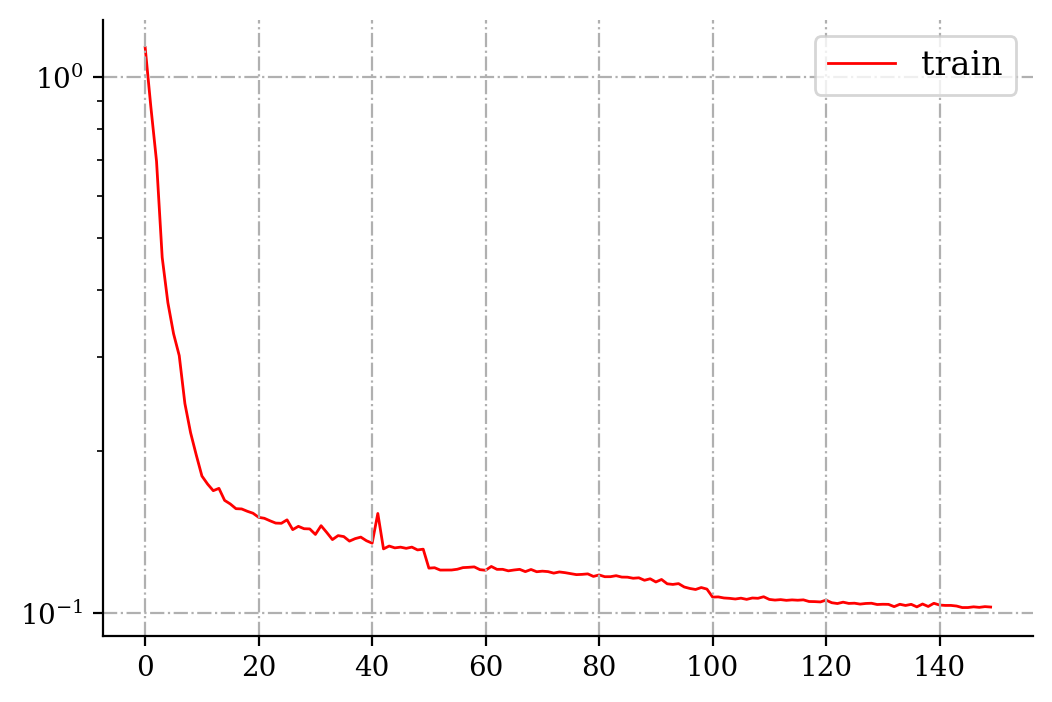

In [12]:
plt.rcParams['font.family'] = 'serif'
          
fig = plt.figure(figsize=(6, 4))

plt.yscale('log')
plt.plot([jnp.mean(jnp.array(epoch)) for epoch in history], linestyle='-', color='red', linewidth=1, zorder=1, label=r'train')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['right'].set_visible(False)

plt.grid(linestyle='-.')
plt.legend(loc='best', fontsize="12");

In [13]:
N_samples = 20
N_iter = min(int(grid*2.5), 400)
A_test, rhs_test = dataset(grid=grid, N_samples=N_samples, key=random.PRNGKey(12))
A_test.shape, rhs_test.shape

((20, 4096, 4096), (20, 4096))

In [14]:
R, values = [], []
for j in tqdm(range(N_samples // 4)):
    _, R_, _, values_ = FCG(A_test[j*4:(j+1)*4], rhs_test[j*4:(j+1)*4], model=model, N_iter=N_iter, m_max=m_max, optimization_specification=optimization_specification, count_values=True)
    R.append(R_)
    values.append(jnp.array(values_))
    
del R_, values_
clear_caches()

R = jnp.concatenate(R, axis=0)
values = jnp.concatenate(values, axis=1).mean(axis=1)
values.shape, R.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:01<00:00, 72.24s/it]


((160,), (20, 4096, 161))

In [15]:
model_ = lambda x: x
R_CG, values_CG = [], []
for j in tqdm(range(N_samples // 4)):
    _, R_, _, values_ = FCG(A_test[j*4:(j+1)*4], rhs_test[j*4:(j+1)*4], model=model_, N_iter=N_iter, m_max=m_max, optimization_specification=optimization_specification, count_values=True)
    R_CG.append(R_)
    values_CG.append(jnp.array(values_))

del R_, values_
clear_caches()
    
R_CG = jnp.concatenate(R_CG, axis=0)
values_CG = jnp.concatenate(values_CG, axis=1).mean(axis=1)
values_CG.shape, R_CG.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:58<00:00, 59.72s/it]


((160,), (20, 4096, 161))

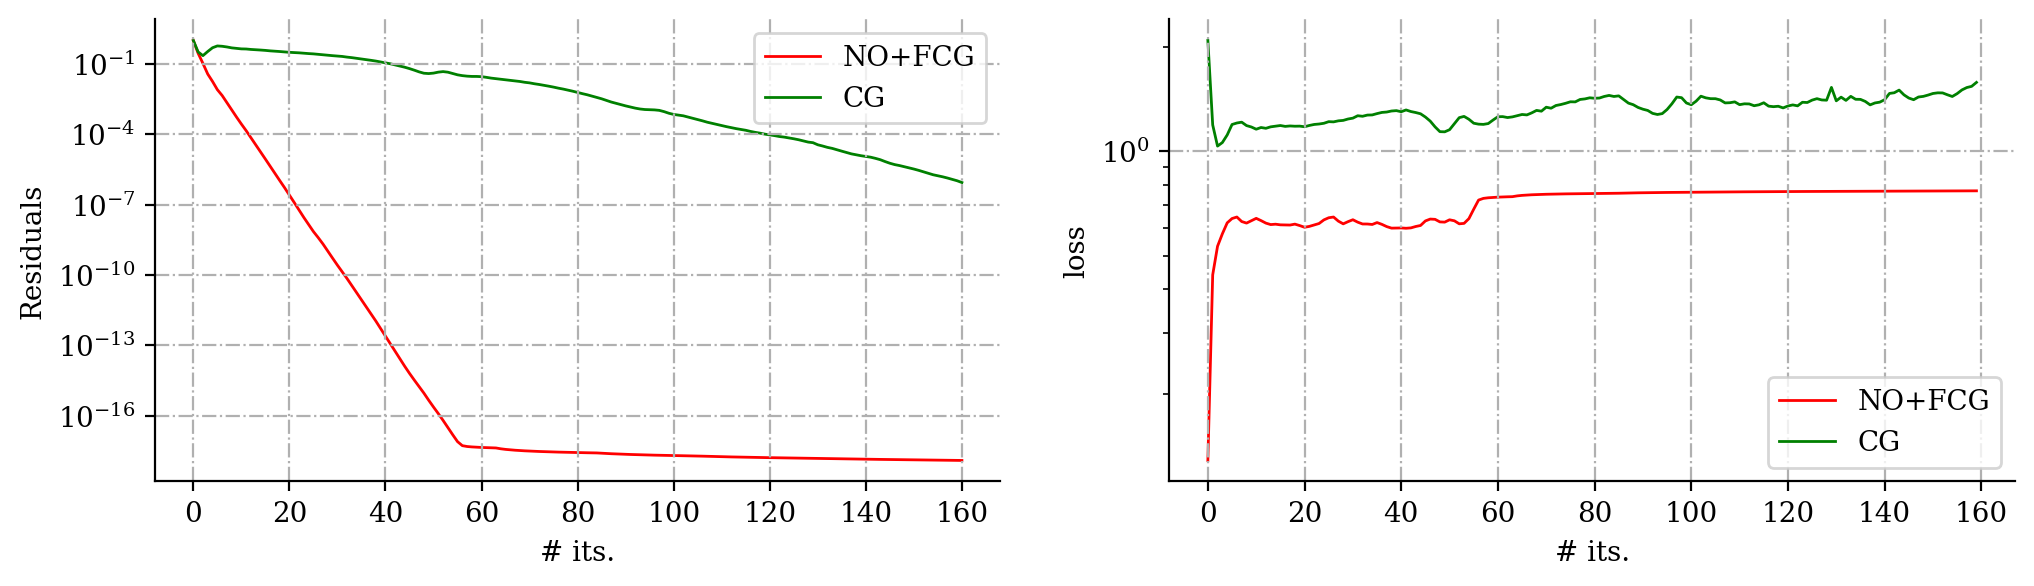

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

norm = jnp.linalg.norm(R[:, :, 0], axis=1)
norm_CG = jnp.linalg.norm(R_CG[:, :, 0], axis=1)

R = jnp.einsum('bij, b -> bij', R, 1. / norm)
R_CG = jnp.einsum('bij, b -> bij', R_CG, 1. / norm_CG)

ax[0].set_yscale('log')
ax[0].plot(jnp.mean(jnp.linalg.norm(R, axis=1), axis=0), linestyle='-', color='red', linewidth=1, zorder=1, label=r'NO+FCG')
ax[0].plot(jnp.mean(jnp.linalg.norm(R_CG, axis=1), axis=0), linestyle='-', color='green', linewidth=1, zorder=1, label=r'CG')
ax[0].grid(linestyle='-.')
ax[0].set_ylabel(r'Residuals')
ax[0].set_xlabel(r'# its.')

ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(True)
ax[0].spines['right'].set_visible(False)

ax[0].legend(loc='best');

ax[1].set_yscale('log')
ax[1].plot(values, linestyle='-', color='red', linewidth=1, zorder=1, label=r'NO+FCG')
ax[1].plot(values_CG, linestyle='-', color='green', linewidth=1, zorder=1, label=r'CG')
ax[1].grid(linestyle='-.')
ax[1].set_ylabel(r'loss')
ax[1].set_xlabel(r'# its.')

ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(True)
ax[1].spines['right'].set_visible(False)

ax[1].legend(loc='best');